# **Project: Amazon Product Recommendation System**

# **Marks: 40**


Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model.

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business.

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:**
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

**Note:** The code has some user defined functions that will be usefull while making recommendations and measure model performance, you can use these functions or can create your own functions.

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

**Installing surprise library**

In [1]:
!pip install surprise

## **Importing the necessary libraries and overview of the dataset**

In [2]:
import warnings                                 # Used to ignore the warning given as output of the code
warnings.filterwarnings('ignore')

import numpy as np                              # Basic libraries of python for numeric and dataframe computations
import pandas as pd

import matplotlib.pyplot as plt                 # Basic library for data visualization
import seaborn as sns                           # Slightly advanced library for data visualization

from collections import defaultdict             # A dictionary output that does not raise a key error

from sklearn.metrics import mean_squared_error  # A performance metrics in sklearn

### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [3]:
# Import the dataset
df = pd.read_csv('ratings_Electronics.csv', header = None) # There are no headers in the data file

df.columns = ['user_id', 'prod_id', 'rating', 'timestamp'] # Adding column names

df_copy = df.copy(deep = True) # Copying the data to another DataFrame

df = df.drop('timestamp', axis = 1) # Dropping timestamp

In [4]:
df.sample(3)

,user_id,prod_id,rating
3711850,A2FSAL5W61EVLC,B003ZSHNG8,3.0
4122371,APHJP0HM726P6,B004GYXRK6,4.0
4840929,AOYYE1YBZARJ9,B005D91G38,4.0


In [5]:
df_copy.head(2)

,user_id,prod_id,rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   user_id  object 
 1   prod_id  object 
 2   rating   float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


In [7]:
df['user_id'].nunique() #number of unique users

4201696

In [8]:
df['prod_id'].nunique() #number of unique products

476002

In [9]:
4201696*476002 # total combinations

2000015699392

* As per the number of unique users and products, there is a possibility of 2000015699392 ratings in the dataset, but we only have 7824482, i.e. not every user has rated every product.
* As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.
* Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.




In [10]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [11]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [12]:
df.shape

(125871, 3)

In [13]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count2 = dict()

for prod in prods:

    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count2:
        ratings_count2[prod] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count2[prod] = 1

In [15]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_prods = []

for prod, num_ratings in ratings_count2.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_prods.append(prod)

df_final = df.loc[~ df.prod_id.isin(remove_prods)]

In [16]:
df_final.shape

(65290, 3)

## **Exploratory Data Analysis**

### **Shape of the data**

### **Check the number of rows and columns and provide observations.**

In [17]:
# Check the number of rows and columns and provide observations
rows, columns = df_final.shape
print("No of rows: ", rows) 
print("No of columns: ", columns) 

No of rows:  65290
No of columns:  3


**The dataframe has 65290 rows and 3 columns**

### **Data types**

In [18]:
# Check Data types and provide observations
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65290 entries, 1310 to 7824427
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  65290 non-null  object 
 1   prod_id  65290 non-null  object 
 2   rating   65290 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.0+ MB


In [19]:
# Find the sum of total ratings count by each user product pair
df_final.groupby(['user_id', 'prod_id']).count()['rating'].sum()

65290

**user_id and prod_id are of type object and rating is type float. There are total of 65290 enteries**

In [20]:
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


### **Checking for missing values**

In [21]:
# Check for missing values present and provide observations
df_final.isnull().sum()

user_id    0
prod_id    0
rating     0
dtype: int64

* There are no missing values in the data.

### **Summary Statistics**

In [22]:
# Summary statistics of 'rating' variable and provide observations
df_final['rating'].describe()

count    65290.000000
mean         4.294808
std          0.988915
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: rating, dtype: float64

* The average rating for products is around 4.3 and minimum is 1.0 indicating users were not satified with a product and did not like it and maximum is 5.0 indicating users loved these products.

### **Checking the rating distribution**

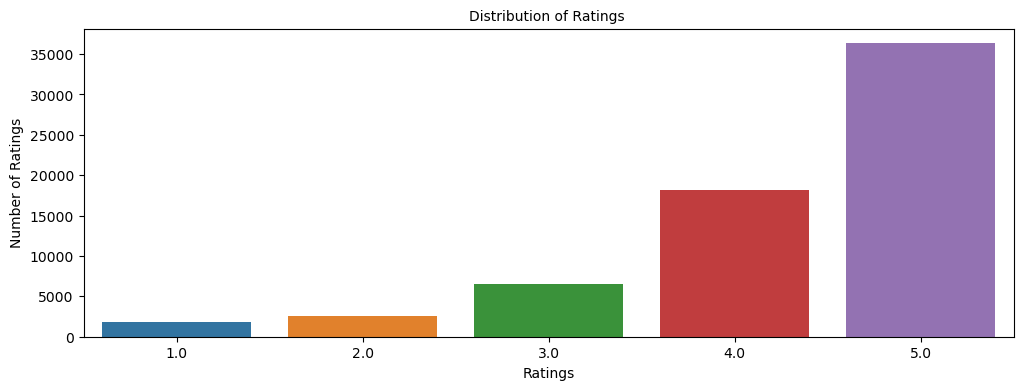

In [23]:
# Distribution of ratings
plt.figure(figsize = (12, 4))
sns.countplot(x="rating", data=df_final)

plt.tick_params(labelsize = 10)
plt.title("Distribution of Ratings ", fontsize = 10)
plt.xlabel("Ratings", fontsize = 10)
plt.ylabel("Number of Ratings", fontsize = 10)
plt.show()

* As per the histogram, the rating '5.0' has the highest count of ratings (~35k) and accounts for the majority of the ratings.
* Following this, Rating '4.0' with ~20k ratings and least ratings are for '1.0' and '2.0'with less than 5k ratings.

### **Checking the number of unique users and items in the dataset**

In [24]:
# Number of total rows in the data and number of unique user id and product id in the data

print('The number of observations in the final data = ', len(df_final))
print('Number of unique USERS in Raw data = ', df_final['user_id'].nunique())
print('Number of unique ITEMS in Raw data = ', df_final['prod_id'].nunique())

The number of observations in the final data =  65290
Number of unique USERS in Raw data =  1540
Number of unique ITEMS in Raw data =  5689


* There are 1540 unique users and 5689 products.

### **Users with the most number of ratings**

In [25]:
# Top 10 users based on the number of ratings
most_rated = df_final['user_id'].value_counts().head(10)
most_rated

user_id
ADLVFFE4VBT8      295
A3OXHLG6DIBRW8    230
A1ODOGXEYECQQ8    217
A36K2N527TXXJN    212
A25C2M3QF9G7OQ    203
A680RUE1FDO8B     196
A1UQBFCERIP7VJ    193
A22CW0ZHY3NJH8    193
AWPODHOB4GFWL     184
AGVWTYW0ULXHT     179
Name: count, dtype: int64

* These users are most active in terms of rating the products. The top 10 users have rated at a minimum of 179 ratings and at most 295 ratings.

In [26]:
# Print a few rows of the new dataset
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [27]:
df_final.shape

(65290, 3)

In [28]:
# Calculate the average rating for each product
average_rating = df_final.groupby('prod_id')['rating'].mean()

# Calculate the count of ratings for each product
count_rating = df_final.groupby('prod_id')['rating'].count()

# Create a dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({'avg_rating':average_rating,'rating_count':count_rating})
# Sort the dataframe by average of ratings in the descending order

final_rating = final_rating.sort_values(by='avg_rating',ascending=False)
# See the first five records of the "final_rating" dataset
final_rating.head(5)

,avg_rating,rating_count
prod_id,,
B00LGQ6HL8,5.0,5
B003DZJQQI,5.0,14
B005FDXF2C,5.0,7
B00I6CVPVC,5.0,7
B00B9KOCYA,5.0,8


In [29]:
final_rating.tail()

,avg_rating,rating_count
prod_id,,
B003O2RVGM,1.833333,12
B000ND75C0,1.833333,6
B007C0Y7RI,1.625000,8
B004OBUFYW,1.400000,5
B000UF3FT8,1.375000,8


In [30]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions
def top_n_products(data,n,min_interaction = 100):
# Finding products with minimum number of interactions
  recommendations = data[data['rating_count']> min_interaction]
# Sorting values with respect to average rating
  recommendations = recommendations.sort_values(by='avg_rating',ascending=False)

  return recommendations[:n]

### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [32]:
top_n_products(final_rating,5,50)

,avg_rating,rating_count
prod_id,,
B001TH7GUU,4.871795,78
B003ES5ZUU,4.864130,184
B0019EHU8G,4.855556,90
B006W8U2MU,4.824561,57
B000QUUFRW,4.809524,84


### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [33]:
top_n_products(final_rating,5)

,avg_rating,rating_count
prod_id,,
B003ES5ZUU,4.864130,184
B000N99BBC,4.772455,167
B007WTAJTO,4.701220,164
B002V88HFE,4.698113,106
B004CLYEDC,4.669492,118


The above calls to the function top_n_products returns the top n products based on average rating and popularity.

We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [34]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold


**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [35]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    print('Precision: ', precision) # Command to print the overall precision

    print('Recall: ', recall) # Command to print the overall recall

    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [36]:
df_for_testing = df_final.copy()

* The df_for_testing will be used for testing the models.

In [37]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(1.0, 5.0))

# Loading the rating dataset
df_final = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)

# Splitting the data into train and test dataset
trainset, testset = train_test_split(df_final, test_size=0.2, random_state=42)

Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [38]:
# Declaring the similarity options
sim_options = {
    'name':'cosine',
    'user_based':True
}

# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
algo_knn_user= KNNBasic(sim_options=sim_options,verbose=False,random_state=1)

# Fit the model on the training data
algo_knn_user.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
precision_recall_at_k(algo_knn_user)

RMSE: 1.0012
Precision:  0.855
Recall:  0.858
F_1 score:  0.856


* We observe that the baseline model has a RMSE = 1.0012 on the testset.
* Recall Intuition: We are getting a recall of 0.855, which means out of all the relevant products, ~85% are recommended.
* Precision Intuition: We are getting a precision of 0.858, which means out of all the products recommended, ~86% are relevant.
* F1_score is 0.856, this indicates that mostly recommended products were relevant and relevant restaurants were recommended. We will try to improve this in GridSearchCV later.

Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [39]:
# Predicting rating for a sample user with an interacted product
algo_knn_user.predict("A3LDPF5FMB782Z","1400501466",r_ui=5.0,verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.40   {'actual_k': 5, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5.0, est=3.4, details={'actual_k': 5, 'was_impossible': False})

The above output shows that the actual rating for this user-item pair is 5.0 and the predicted rating is 3.40 by the user-user similarity based model. This implies that model is under estimating the ratings.

Below is the **list of users who have not seen the product with product id "1400501466"**.

In [40]:
u_id="A34BZM6S9L7QI4"
p_id="1400501466"
unique_users = df[df.prod_id != p_id].user_id.unique()
if u_id in unique_users:
    print(f"The user_id {u_id} has not interacted with the product_id {p_id}.")
else:
    print(f"The user_id {u_id} has interacted with the product_id {p_id}.")

The user_id A34BZM6S9L7QI4 has not interacted with the product_id 1400501466.


* It can be observed from the above list that **user "A34BZM6S9L7QI4" has not seen the product with productId "1400501466"** as this userId is a part of the above list.

**Below we are predicting rating for `userId=A34BZM6S9L7QI4` and `prod_id=1400501466`.**

In [41]:
# Predicting rating for a sample user with a non interacted product
algo_knn_user.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

* We observe that the rating for this user-item pair is 4.29 but the prediction is not reliable due to insufficient similar users in the dataset. This is a common issue in collaborative filtering models when there is limited data for making accurate predictions.

### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [42]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30, 40], 
              'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine','pearson','pearson_baseline'],
                              'user_based': [True]}
              }

# Performing 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# Fitting the data
gs.fit(df_final)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9725801658171443
{'k': 40, 'min_k': 6, 'sim_options': {'name': 'cosine', 'user_based': True}}


Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [43]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options = {
    'name': 'msd',
    'user_based': True
}

# Creating an instance of KNNBasic with optimal hyperparameter values
algo_knn_user_optimized = KNNBasic(sim_options = sim_options, k = 40, min_k = 6, random_state = 1)

# Training the algorithm on the trainset
algo_knn_user_optimized.fit(trainset)
# Let us compute precision@k and recall@k also with k =10
precision_recall_at_k(algo_knn_user_optimized)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9530
Precision:  0.847
Recall:  0.893
F_1 score:  0.869


* After tuning the hyperparamenters, RMSE for the test set has reduce to 0.9530 from 1.0250.
* We can observe that the tuned model's F1 score and Recall increased in comparison to the baseline model with a slight drop in the Precision. We can say that the model's performance has imporved overall after the tuning.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [46]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
algo_knn_user_optimized.predict("A3LDPF5FMB782Z","1400501466",r_ui=5.0,verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5.0, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

In [47]:
# Use sim_user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
algo_knn_user_optimized.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

* For the userId "A3LDPF5FMB782Z" and productId 1400501466, the prodiction has improved significantly from 3.0 to 4.29 which is closer to actual of 5.0.
* For the userId "A34BZM6S9L7QI4" and productId "1400501466", the prediction remained the same.

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [48]:
# 0 is the inner id of the above user
algo_knn_user_optimized.get_neighbors(0, k=5)

[6, 42, 44, 54, 66]

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [49]:
import pandas as pd

def get_recommendations(data, user_id, top_n, algo):
    """
    Generate recommendations for a user based on a similarity-based recommendation engine.

    Parameters:
    data (pd.DataFrame): DataFrame containing user-item interactions with columns ['user_id', 'prod_id', 'rating'].
    user_id (str): The user ID for whom recommendations are to be generated.
    top_n (int): The number of top recommendations to return.
    algo: The recommendation algorithm object with a predict method.

    Returns:
    list: A list of tuples containing recommended product IDs and their predicted ratings.
    """
    # Creating an empty list to store the recommended product IDs
    recommendations = []

    # Creating a user-item interactions matrix
    user_item_interactions_matrix = data.pivot(index='user_id', columns='prod_id', values='rating')

    # Extracting those product IDs which the user_id has not interacted with yet
    if user_id in user_item_interactions_matrix.index:
        non_interacted_items = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()
    else:
        # If the user_id does not exist in the matrix, consider all product IDs as non-interacted
        non_interacted_items = user_item_interactions_matrix.columns.tolist()

    # Looping through each of the product IDs which user_id has not interacted with yet
    for prod_id in non_interacted_items:
        # Predicting the ratings for those non-interacted product IDs by this user
        est = algo.predict(user_id, prod_id).est
        # Appending the predicted ratings
        recommendations.append((prod_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)

    return recommendations[:top_n]  # Returning top n predicted rating items for this user


In [50]:
#df_for_testing.shape (65290, 3)
df_for_testing=df_for_testing.drop_duplicates()
df_for_testing.shape

(65290, 3)

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [51]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
recommendations = get_recommendations(df_for_testing, "A3LDPF5FMB782Z", 5, algo_knn_user_optimized)

In [52]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,B000067RT6,5.0
1,B000BQ7GW8,5.0
2,B001TH7GUU,5.0
3,B004RORMF6,5.0
4,B005ES0YYA,5.0


### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [53]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': False}

# KNN algorithm is used to find desired similar items
algo_knn_item = KNNBasic(sim_options = sim_options, random_state = 1, verbose = False)

# Train the algorithm on the train set, and predict ratings for the test set
algo_knn_item.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(algo_knn_item)

RMSE: 0.9950
Precision:  0.838
Recall:  0.845
F_1 score:  0.841


* The baseline Item-Item similarity model has RMSE - 0.995, Precision of ~84% and Recall of ~84.5% and F1 score of ~84%. Overall, it does well. Let us try to optimize it.

Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [54]:
# Predicting rating for a sample user with an interacted product
algo_knn_item.predict("A3LDPF5FMB782Z","1400501466",r_ui=5.0,verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.27   {'actual_k': 22, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5.0, est=4.2727272727272725, details={'actual_k': 22, 'was_impossible': False})

* We can see that the estimated rating is 4.27 which is the good prediction.

Below we are **predicting rating for the `userId = A34BZM6S9L7QI4` and `prod_id = 1400501466`**.

In [55]:
# Predicting rating for a sample user with a non interacted product
algo_knn_item.predict("A34BZM6S9L7QI4","1400501466",verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

* The estimated rating is 4.29 and the same issue as with the user basel model with not having enough neighbours.

### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters

In [56]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30], 
              'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [False]}
              }

# Performing 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# Fitting the data
gs.fit(df_final)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9752228976919293
{'k': 20, 'min_k': 6, 'sim_options': {'name': 'msd', 'user_based': False}}


Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [57]:
# Using the optimal similarity measure for item-item based collaborative filtering
sim_options = {
    'name':'msd',
    'user_based': False
}

# Creating an instance of KNNBasic with optimal hyperparameter values
algo_knn_item_optimized = KNNBasic(sim_options=sim_options ,k = 20 ,min_k = 6 , random_state = 1, verbose = False)

# Training the algorithm on the train set
algo_knn_item_optimized.fit(trainset)


# Let us compute precision@k and recall@k, f1_score and RMSE
precision_recall_at_k(algo_knn_item_optimized)

RMSE: 0.9578
Precision:  0.839
Recall:  0.88
F_1 score:  0.859


* After tuning the hyperparameters for the Item based similarity model, RMSE for the test set has reduced compared to the caseline item-item based model.
* We can observe that the Precision and F1 score did not change much however the Recall went up to 88%.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [58]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
algo_knn_item_optimized.predict("A3LDPF5FMB782Z","1400501466",r_ui=5.0,verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.71   {'actual_k': 20, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5.0, est=4.7105263157894735, details={'actual_k': 20, 'was_impossible': False})

In [59]:
# Use sim_item_item_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
algo_knn_item_optimized.predict("A34BZM6S9L7QI4","1400501466",verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

* The prediction for the estimated rating for a user-product pair went up to 4.71 with actual as 5.0. This is the best prediction so far in comparison to all the models.
* The prediction for a user-product pair with no interaction remained the same at 4.29.

### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [60]:
algo_knn_item_optimized.get_neighbors(0,k=5)

[29, 53, 67, 106, 151]

**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [61]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
recommendations = get_recommendations(df_for_testing,"A1A5KUIIIHFF4U", 5, algo_knn_item_optimized)

In [62]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,1400532655,4.292024
1,1400599997,4.292024
2,9983891212,4.292024
3,B00000DM9W,4.292024
4,B00000J1V5,4.292024


Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [63]:
# Using SVD matrix factorization. Use random_state = 1
svd= SVD(random_state=1)
# Training the algorithm on the trainset
svd.fit(trainset)
# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd)

RMSE: 0.8882
Precision:  0.853
Recall:  0.88
F_1 score:  0.866


* This model seems to the okay overall in terms of the metrics such as RMSE (0.88), Precison ( around 85%) and F1 score (around 86%).

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [64]:
# Making prediction
svd.predict("A3LDPF5FMB782Z","1400501466",r_ui=5.0,verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.08   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5.0, est=4.081406749810685, details={'was_impossible': False})

* Though the metrics were better than the other models, the prediction is not as we can observe that estimated rating is 4.08 and actual was 5.0

**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [65]:
# Making prediction
svd.predict("A34BZM6S9L7QI4","1400501466",verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.40   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.400375680469341, details={'was_impossible': False})

* This has increased to 4.4 from 4.29 compared to other models.

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [66]:
# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30],
              'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

# Performing 3-fold gridsearch cross validation
gs_ = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# Fitting data
gs_.fit(df_final)

# Best RMSE score
print(gs_.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs_.best_params['rmse'])

0.8979502721196223
{'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.2}


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [67]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state=1
svd_optimized= SVD(n_epochs=20,lr_all=0.01, reg_all=0.2,random_state=1)
# Train the algorithm on the trainset
svd_optimized= svd_optimized.fit(trainset)
# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd_optimized)

RMSE: 0.8808
Precision:  0.854
Recall:  0.878
F_1 score:  0.866


* Compared to the baseline SVD model, metrics did not change much.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [68]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
svd_optimized.predict("A3LDPF5FMB782Z","1400501466",r_ui=5.0,verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.13   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5.0, est=4.128589011282042, details={'was_impossible': False})

In [69]:
# Use svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
svd_optimized.predict("A34BZM6S9L7QI4","1400501466",verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.22   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.216280997100113, details={'was_impossible': False})

Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computi

* Estimated ratings are not close to actual. Estimate is at 4.13 compared to 5 which is actual.
* For user-product product pair, this estimate also does not improve.

### **Conclusion and Recommendations**

* In this project, we built recommendation systems using four different algorithms, they are
    - Rank-based using averages
    - User-User similarity collaborative filtering
    - Item-Item similarity collaborative filtering
    - Model-based (matrix factorization) collaborative filtering
* To demonstrate "user-user similarity-based collaborative filtering", "item-item similarity-based collaborative filtering", and "model-based (matrix factorization) collaborative filtering", surprise library has been used. For these algorithms, grid search cross-validation is used to find the optimal hyperparameters for the data, and improve the performance of the model.

* For performance evaluation of these models, precision@k and recall@k are used. Using these two metrics, the F_1 score is calculated for each working model.

* Overall, the **optimized user-user similarity-based recommendation system** has given the best performance in terms of the F1-Score (85.9%)

* Collaborative Filtering searches for neighbors based on similarity of products (example) preferences and recommend products that those neighbors read while Matrix factorization works by decomposing the user-item matrix into the product of two lower dimensionality rectangular matrices.

* Matrix Factorization has lowest RMSE due to the reason that it assumes that both products and users are present in some low dimensional space describing their properties and recommend a product based on its proximity to the user in the latent space. Implying it accounts for latent factors as well.

* In a future scope, we can also try to combine different recommendation techniques to build a more complex model like hybrid recommendation systems.